# CLINT WP5: MultiMaps of anomaly of drivers (w/r to 1981-2010) in detected areas and periods. 
## Upgrade to the use of reanalysis (ERA5) and historical (CMIP6) on DKRZ-Levante

## How to get data and calculate anomalies, store them to avoid long computational time next round
### 2023/11/02 - 2023/11/09

## Graphical improvements
### 2023/11/14

## Gradual inclusion of new variables (soil moisture,geopotential)
### 2023/11/13 - ongoing


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy
import importlib
import seaborn as sns
import matplotlib.ticker as mticker
import os
import time

from cdo import *
cdo = Cdo()

import CLINT001_functions as clint
importlib.reload(clint)

<module 'CLINT001_functions' from '/home/b/b382649/CLINT_WP5/CLINT001_functions.py'>

In [2]:
## DIRECTORIES
machine = 'DKRZ'
kind = 'ERA5' #ERA5 or hist
experiment = 5


if machine == 'laptop':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    metadatadir = '~/Library/Mobile\ Documents/com~apple~CloudDocs/CLINT/metadata/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    plotdir = '/Users/squintu/Documents/CMCC-GoogleDrive/plots_for_reports/'
    
if machine == 'workstation':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    metadatadir = '~/Library/Mobile\ Documents/com~apple~CloudDocs/CLINT/metadata/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    plotdir = '/Users/antonellosquintu/Documents/CMCC-GoogleDrive/plots_for_reports/'

if machine == 'juno':
    repodir = '/home/b/b382649/CLINT_WP5'
    obsdir = repodir
    modeldir = f'/work/csp/as18623/CLINT_{kind}/'
    workmetadir = '/work/csp/as18623/CLINT_metadata/'
    metadatadir = '/data/csp/as18623/CLINT_metadata/'
    maskdir = '/data/csp/as18623/CLINT_metadata/Masks/Test3_Clusters/'
    plotdir = '/work/csp/as18623/CLINT_WP5/maps_and_plots/'
    
if machine == 'DKRZ':
    if kind == 'ERA5':
        modeldir1 = f"/work/bm1159/XCES/data4xces/reanalysis/reanalysis/ECMWF/IFS/ERA5/day/atmos/" #where are the model data?    
        workdir = "/work/bk1318/b382649/ERA5/"
    obsdir = '/home/b/b382649/CLINT_WP5/obs/'    
    workmetadir = '/home/b/b382649/CLINT_WP5/metadata/'
    metadatadir = '/home/b/b382649/CLINT_WP5/metadata/'
    maskdir = '/home/b/b382649/CLINT_WP5/Mask_Clusters/' #not necessary anymore
    plotdir = '/work/csp/as18623/CLINT_WP5/maps_and_plots/' #not plotting at the momenbt

In [3]:
modelspecs = pd.DataFrame({'kind':['ERA5','hist'],
                           'modelnames':['era5','CMCC-CM2-SR5'],#name of models
                           'members_list':[np.nan,np.array(range(3,12))]})#list of member numbers)

modelspecs = pd.DataFrame({'kind':['ERA5','hist'],
                           'model_names':['era5','CMCC-CM2-SR5'],#name of models
                           'members_list':[[1],[2]],
                           'model_path':["/work/bm1159/XCES/data4xces/reanalysis/reanalysis/ECMWF/IFS/ERA5/",
                                          np.nan],
                            'work_path':["/work/bk1318/b382649/ERA5/",np.nan]})#list of member numbers)


In [4]:
modelspecs.model_path.values

array(['/work/bm1159/XCES/data4xces/reanalysis/reanalysis/ECMWF/IFS/ERA5/',
       nan], dtype=object)

In [5]:
varspecs = pd.read_csv(f'{workmetadir}variables_specifications.csv')

In [6]:
## Open land-sea mask and round to integer
## The mask has values between 0 and 1 according to the proportion of the grid-point
##  which is covered by land
## Any gridpoint with more than 0.5 is rounded to 1 and considered land

lsm = xr.open_dataset(f'{metadatadir}/era5_lsm.nc').round()

In [7]:
### Read series of tmax and HWMI related to Lake Como
lchw = pd.read_csv(f'{obsdir}/LakeComo_tmax_HW.csv',index_col='date')

In [8]:
### Identify 2019 heat wave

row_maxHWMI = lchw.loc[lchw['Valle_HWintensity'].idxmax()]
date2019_dt = dt.strptime(row_maxHWMI.name,"%Y-%m-%d")
date2019_ts = pd.to_datetime(date2019_dt)

In [9]:
### Identify dates
date_aux_dt = dt.strptime(lchw.loc[lchw.year==1983]['Valle_HWintensity'].idxmax(),"%Y-%m-%d")
date_aux_ts = pd.to_datetime(date_aux_dt)

In [10]:
variables = ['olr']


In [11]:
## indicate the date of the events and the variables to be included

dates_ts = (pd.to_datetime("2022-07-22"), 
            pd.to_datetime("2019-06-27"), 
            pd.to_datetime("2003-08-11"), 
            pd.to_datetime("1983-07-21"))

## don't run too many dates at once otherwise the notebook won't open next time

dates_ts =[pd.to_datetime("2003-08-11")]
if kind == 'ERA5':
    houroffset = 0 #daily files of era5 are labeled with 00 UTC
else:
    houroffset = 12 #daily files of CMIP6 are labeled with 12 UTC

dates_ts1 = dates_ts
dates_ts = [d + pd.DateOffset(hours = houroffset) for d in dates_ts1]





In [12]:
drivers = pd.read_csv(f'{workmetadir}drivers{experiment}_Test.csv')
drivers

var era5cds_var era5cmor_var cmip6_var     unit  exp exp_size  domain  \
0   tmax         NaN       tasmax    tasmax       °C  5.0      low  Europe   
1   tmax         NaN       tasmax    tasmax       °C  5.0      low  Europe   
2   mslp         NaN          psl       psl      hPa  5.0      low  Europe   
3   mslp         NaN          psl       psl      hPa  5.0      low   World   
4     sm         NaN        swvl1     mrsos  m^3/m^3  5.0      low  Europe   
5     sm         NaN        swvl1     mrsos  m^3/m^3  5.0      low  Europe   
6     sm         NaN        swvl1     mrsos  m^3/m^3  5.0      low  Europe   
7   z500        z500           zg        zg        m  5.0      low  Europe   
8   z500        z500           zg        zg        m  5.0      low  Europe   
9     tp          tp           pr        pr   mm/day  5.0      low  Europe   
10    tp          tp           pr        pr   mm/day  5.0      low  Europe   
11   sic         sic          sic       sic        %  5.0      low   Artic   
12   sst         sst          tos       tos        C  5.0      low   World   
13   olr         olr         rlut      rlut    W/m^2  5.0      low   World   
14   olr         olr         rlut      rlut    W/m^2  5.0      low   World   

    cl_nr              cl_name  ...  cl_ext_S  cl_ext_N   vmin   vmax  \
0     1.0  cl5low_Europe1_tmax  ...      42.0      58.0  -15.0   15.0   
1     2.0  cl5low_Europe2_tmax  ...      39.0      63.5  -15.0   15.0   
2     3.0  cl5low_Europe3_mslp  ...      57.0      71.0 -250.0  250.0   
3     2.0   cl5low_World2_mslp  ...     -76.0     -46.5 -250.0  250.0   
4     1.0    cl5low_Europe1_sm  ...      42.0      62.0   -0.2    0.2   
5     2.0    cl5low_Europe2_sm  ...      29.0      71.0   -0.2    0.2   
6     5.0    cl5low_Europe5_sm  ...      34.0      51.0   -0.2    0.2   
7     4.0  cl5low_Europe4_z500  ...      29.0      55.0 -400.0  400.0   
8     5.0  cl5low_Europe5_z500  ...      44.5      60.5 -400.0  400.0   
9     1.0    cl5low_Europe1_tp  ...      44.5      68.5   -5.0   15.0   
10    3.0    cl5low_Europe3_tp  ...      35.5      49.0   -5.0   15.0   
11    5.0    cl5low_Artic5_sic  ...      55.0      82.0  -50.0   50.0   
12    3.0    cl5low_World3_sst  ...     -23.5      29.0    NaN    NaN   
13    2.0    cl5low_World2_olr  ...     -15.5      12.5  -50.0    NaN   
14    3.0    cl5low_World3_olr  ...     -13.5       8.5  -50.0    NaN   

    text_plot_lon  text_plot_lat  fig_width  ax_width  ax_height  empty  
0             NaN            NaN        NaN       NaN        NaN    NaN  
1             NaN            NaN        NaN       NaN        NaN    NaN  
2             NaN            NaN        NaN       NaN        NaN    NaN  
3             NaN            NaN        NaN       NaN        NaN    NaN  
4             NaN            NaN        NaN       NaN        NaN    NaN  
5             NaN            NaN        NaN       NaN        NaN    NaN  
6             NaN            NaN        NaN       NaN        NaN    NaN  
7             NaN            NaN        NaN       NaN        NaN    NaN  
8             NaN            NaN        NaN       NaN        NaN    NaN  
9             NaN            NaN        NaN       NaN        NaN    NaN  
10            NaN            NaN        NaN       NaN        NaN    NaN  
11            NaN            NaN        NaN       NaN        NaN    NaN  
12            NaN            NaN        NaN       NaN        NaN    NaN  
13            NaN            NaN        NaN       NaN        NaN    NaN  
14            NaN            NaN        NaN       NaN        NaN    NaN  

[15 rows x 32 columns]

This variable does not have a customized palette


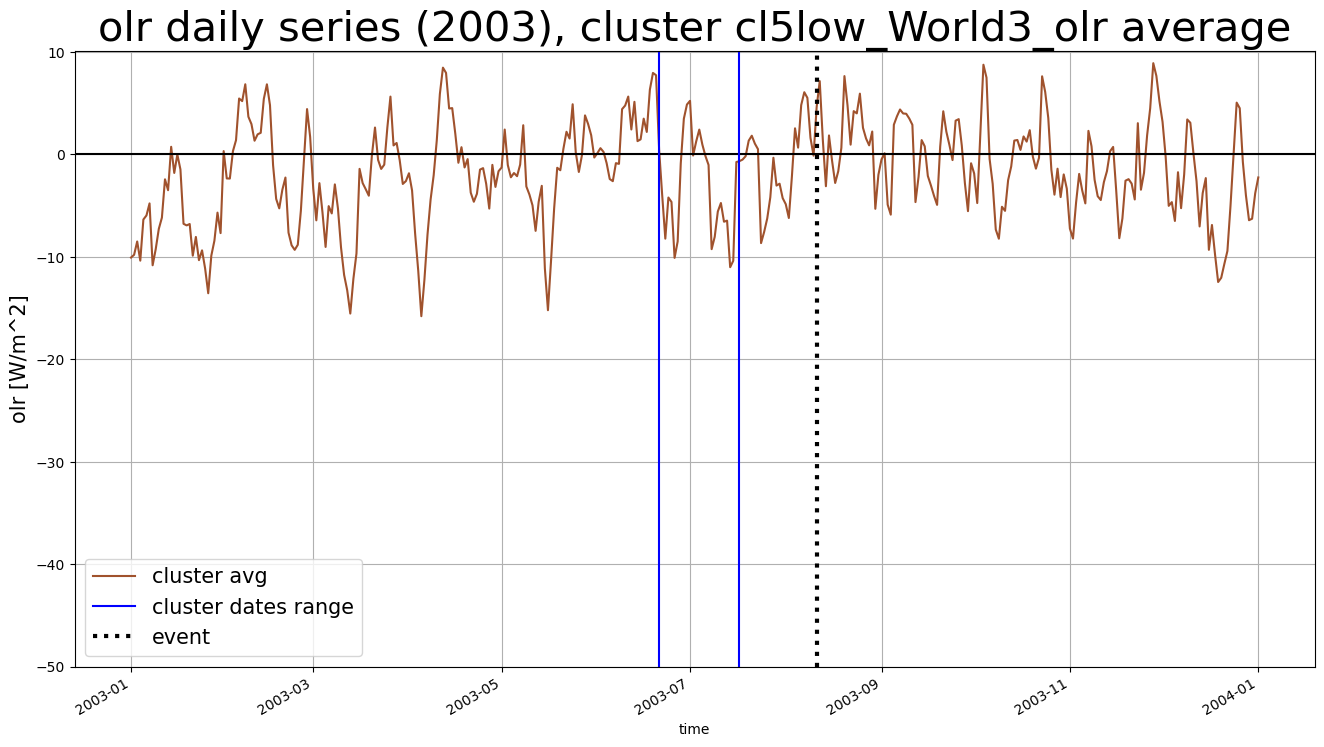

In [ ]:
importlib.reload(clint)
varspecs = pd.read_csv(f'{workmetadir}variables_specifications.csv')
drivers = pd.read_csv(f'{workmetadir}drivers{experiment}_Test.csv')
tstart = time.time()
clint.loop_map_grids(drivers.iloc[[11,14]], dates_ts, variables, lsm, modelspecs, varspecs, 
                     machine, workdir, modeldir1, maskdir, plotdir)
tstop = time.time()
print(tstop-tstart)